# mini_project_3.ipynb

Group Members:
- Peter Bollhorn
- Tobias Thormod Birk Nielsen

This notebook presents our solution to Mini Project 3, where we work with data from The Movie Database (TMDB) https://www.themoviedb.org/

In the notebook **read_tmdb_data.ipynb** we read JSON data from TMDB's API and store it as CSV files:
- **danish_movies.csv**: Data on all Danish-language movies ever made up to and including 2024-12-31.
- **danish_actors.csv**: Data on all actors that appear in these movies (also foreign actors).

Here is what we do in the different tasks:
- Task 1: We load the two CSV files into data frames, and then we clean them and prepare them for the next tasks.
- Task 2: We use linear regression to see if there is a linear relationship between actor age and their movie count (the number of movies they have appeared in).
- Task 3: We use classiciation to see if we can predict actor gender from their age and their movie count.
- Task 4: We use clustering to see (FILL IN HERE)


TMDB works with these genders:
| value  | Gender                  |
|--------|-------------------------|
| 0      | Not set / not specified |
| 1      | Female                  |
| 2      | Male                    |
| 3      | Non-binary              |

And TMDB works with these genres:
| genre_id | Genre           |
|----------|-----------------|
| 28       | Action          |
| 12       | Adventure       |
| 16       | Animation       |
| 35       | Comedy          |
| 80       | Crime           |
| 99       | Documentary     |
| 18       | Drama           |
| 10751    | Family          |
| 14       | Fantasy         |
| 36       | History         |
| 27       | Horror          |
| 10402    | Music           |
| 9648     | Mystery         |
| 10749    | Romance         |
| 878      | Science Fiction |
| 10770    | TV Movie        |
| 53       | Thriller        |
| 10752    | War             |
| 37       | Western         |

In [1]:
import sys
sys.path.append("..")

import pandas as pd
import ast  # Abstract Syntax Trees - safely parse string list to Python list
import seaborn as sns
import matplotlib.pyplot as plt
from reader import generic_reader

## Task 1: Data wrangling and exploration

First we read in danish_movies.csv and have a look at the data. We see that there is a total of 5134 movies.

In [2]:
danish_movies = generic_reader.read_csv_file_to_data_frame("movie_data/danish_movies.csv")
print(danish_movies.info())
danish_movies

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623 entries, 0 to 1622
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1623 non-null   int64  
 1   title            1623 non-null   object 
 2   release_date     1623 non-null   object 
 3   runtime          1623 non-null   int64  
 4   vote_average     1623 non-null   float64
 5   vote_count       1623 non-null   int64  
 6   genre_ids        1623 non-null   object 
 7   cast_person_ids  1623 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 101.6+ KB
None


,id,title,release_date,runtime,vote_average,vote_count,genre_ids,cast_person_ids
0,77133,The Abyss,1910-09-12,41,6.3,47,[18],"[55143, 579016, 1268912, 1685436, 1886257, 127..."
1,786475,In the Hands of Imposters,1911-01-23,47,4.0,1,"[18, 80, 10749]","[89676, 1272279, 1415764, 1268297, 29039, 9367..."
2,292179,Temptations of a Great City,1911-03-06,41,5.5,14,[18],"[1174479, 89676, 1268863, 1415763, 936779, 127..."
3,629224,A Homeless Bird,1911-05-08,42,2.0,1,[],"[1170362, 29037, 936780, 936783, 2405426]"
4,283512,The Girl Behind the Counter,1911-08-12,52,0.0,0,"[18, 10749]","[89676, 1017884, 1017488, 1040932, 29044, 1272..."
...,...,...,...,...,...,...,...,...
1618,1398305,BROS - Så Blev der Mørkt,2024-12-06,74,8.0,1,[35],"[2328180, 2208065, 587169, 1444569]"
1619,1263071,Bloodsucker,2024-12-17,94,0.0,0,[27],"[4608404, 2190163, 2094504, 2350923, 1899167, ..."
1620,1407564,Martin Kanstrup - TRÆLS,2024-12-21,119,0.0,0,"[10402, 35]",[4991732]
1621,1408690,Christopher - A Beautiful Live Tour,2024-12-22,72,0.0,0,[10402],[2956800]


Now we read in danish_actors.csv and have a look at the data. We see that a total of 15602 actors appear in these movies (including foreign actors).

In [3]:
danish_actors = generic_reader.read_csv_file_to_data_frame("movie_data/danish_actors.csv")
print(danish_actors.info())
danish_actors

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3530 entries, 0 to 3529
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   actor_id     3530 non-null   int64 
 1   name         3530 non-null   object
 2   gender       3530 non-null   int64 
 3   birthday     3530 non-null   object
 4   deathday     1014 non-null   object
 5   movie_count  3530 non-null   int64 
 6   age          3530 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 193.2+ KB
None


,actor_id,name,gender,birthday,deathday,movie_count,age
0,42,Lars von Trier,2,1956-04-30,NaN,9,68
1,53,Peter Stormare,2,1953-08-27,NaN,1,71
2,169,Hanns Zischler,2,1947-06-18,NaN,1,77
3,378,Jonathan Pryce,2,1947-06-01,NaN,1,77
4,517,Pierce Brosnan,2,1953-05-16,NaN,1,71
...,...,...,...,...,...,...,...
3525,5072279,Jakob Engel-Schmidt,2,1983-10-24,NaN,1,41
3526,5122551,Bertram Lyng Engelsted Jarkilde,2,2008-10-29,NaN,1,16
3527,5208961,Daniel 'Danny Kool' Sørensen,2,1986-01-09,NaN,1,38
3528,5244450,Gert Henning-Jensen,2,1965-07-23,NaN,1,59


For danish_movies data frame, we now drop the columns we are not interested in working with.

And we convert string representations of lists to actual Python lists.

And we convert string representation of release_date to actual Python datetime objects.

In [4]:
columns_to_keep = ['id', 'title', 'release_date', 'runtime', 'vote_average', 'vote_count', 'genre_ids', 'cast_person_ids']
danish_movies = danish_movies[columns_to_keep].copy()
danish_movies['genre_ids'] = danish_movies['genre_ids'].apply(ast.literal_eval)
danish_movies['cast_person_ids'] = danish_movies['cast_person_ids'].apply(ast.literal_eval)
danish_movies['release_date'] = pd.to_datetime(danish_movies['release_date'])
danish_movies

,id,title,release_date,runtime,vote_average,vote_count,genre_ids,cast_person_ids
0,77133,The Abyss,1910-09-12,41,6.3,47,[18],"[55143, 579016, 1268912, 1685436, 1886257, 127..."
1,786475,In the Hands of Imposters,1911-01-23,47,4.0,1,"[18, 80, 10749]","[89676, 1272279, 1415764, 1268297, 29039, 9367..."
2,292179,Temptations of a Great City,1911-03-06,41,5.5,14,[18],"[1174479, 89676, 1268863, 1415763, 936779, 127..."
3,629224,A Homeless Bird,1911-05-08,42,2.0,1,[],"[1170362, 29037, 936780, 936783, 2405426]"
4,283512,The Girl Behind the Counter,1911-08-12,52,0.0,0,"[18, 10749]","[89676, 1017884, 1017488, 1040932, 29044, 1272..."
...,...,...,...,...,...,...,...,...
1618,1398305,BROS - Så Blev der Mørkt,2024-12-06,74,8.0,1,[35],"[2328180, 2208065, 587169, 1444569]"
1619,1263071,Bloodsucker,2024-12-17,94,0.0,0,[27],"[4608404, 2190163, 2094504, 2350923, 1899167, ..."
1620,1407564,Martin Kanstrup - TRÆLS,2024-12-21,119,0.0,0,"[10402, 35]",[4991732]
1621,1408690,Christopher - A Beautiful Live Tour,2024-12-22,72,0.0,0,[10402],[2956800]


For danish_actors data frame, we now drop the columns we are not interested in working with.

And we convert string representation of dates to actual Python datetime objects.

In [5]:
columns_to_keep = ['actor_id', 'name', 'gender', 'birthday', 'deathday']
danish_actors = danish_actors[columns_to_keep].copy()
danish_actors['birthday'] = pd.to_datetime(danish_actors['birthday'])
danish_actors['deathday'] = pd.to_datetime(danish_actors['deathday'])
danish_actors

,actor_id,name,gender,birthday,deathday
0,42,Lars von Trier,2,1956-04-30,NaT
1,53,Peter Stormare,2,1953-08-27,NaT
2,169,Hanns Zischler,2,1947-06-18,NaT
3,378,Jonathan Pryce,2,1947-06-01,NaT
4,517,Pierce Brosnan,2,1953-05-16,NaT
...,...,...,...,...,...
3525,5072279,Jakob Engel-Schmidt,2,1983-10-24,NaT
3526,5122551,Bertram Lyng Engelsted Jarkilde,2,2008-10-29,NaT
3527,5208961,Daniel 'Danny Kool' Sørensen,2,1986-01-09,NaT
3528,5244450,Gert Henning-Jensen,2,1965-07-23,NaT


In the danish_movies data frame we drop all movies that have runtime shorter than 40 minutes.

We also drop animation films (genre_id=16) and documentaries (genre_id=99).

This is because we only want to work with films that are:
- **Feature-length** (excluding short-films)
- **Live-action** (excluding animation films)
- **Narrative** (excluding documentaries)

After doing this we have 1623 films left.

In [6]:
danish_movies = danish_movies[danish_movies["runtime"] >= 40]
danish_movies = danish_movies[~danish_movies['genre_ids'].apply(lambda genre_id: 16 in genre_id or 99 in genre_id)]
len(danish_movies)

1623

Now we drop all actors that do not appear in the reduced danish_movies data frame.

After doing this we have 10651 actors left.

In [7]:
# Step 1: Get all unique actor IDs from danish_movies
all_actor_ids = set()
for cast in danish_movies['cast_person_ids']:
    all_actor_ids.update(cast)
    
# Step 2: Reduce danish_actors to only contain those who appear in the reduced danish_movies data frame
danish_actors = danish_actors[danish_actors['actor_id'].isin(all_actor_ids)].copy()
len(danish_actors)

3530

Now we calculate movie_count for the actors

In [8]:
# Step 1: explode cast_person_ids so each row has one actor per movie
exploded = danish_movies.explode("cast_person_ids")

# Step 2: count movies per actor
actor_movie_counts = (
    exploded.groupby("cast_person_ids")["id"]
    .nunique()  # use nunique in case of duplicates
    .reset_index()
    .rename(columns={"cast_person_ids": "actor_id", "id": "movie_count"})
)
actor_movie_counts

# Step 3: merge movie_count back into danish_actors
danish_actors = danish_actors.merge(actor_movie_counts, on="actor_id")
danish_actors.sort_values(by="movie_count", ascending=False)

,actor_id,name,gender,birthday,deathday,movie_count
721,114719,Karl Stegger,2,1913-01-11,1980-04-13,116
343,47151,Ove Sprogøe,2,1919-12-21,2004-09-14,115
722,114720,Poul Reichhardt,2,1913-02-02,1985-10-31,79
342,47150,Dirch Passer,2,1926-05-18,1980-09-03,79
1218,568922,Henry Nielsen,2,1890-11-01,1967-05-12,77
...,...,...,...,...,...,...
10,955,Penélope Cruz,1,1974-04-28,NaT,1
11,1004,Danny Aiello,2,1933-06-20,2019-12-12,1
15,1021,Stine Bjerregaard,1,1986-09-05,NaT,1
20,1083,Armin Rohde,2,1955-04-04,NaT,1


We drop actors whose birthday is missing

In [9]:
danish_actors = danish_actors.dropna(subset=["birthday"]).copy()
len(danish_actors)

3530

We now calculate the age of the actors:
- For living actors: Their age as of 2024-12-31
- For deceased actors: Their age at the time of passing

And hereafter we look at actors when sorted by age.

In [10]:
def calculate_age_from_row(row):
    birthday = row['birthday']
    deathday = row['deathday']
    
    if pd.isna(deathday):
        end_date = pd.to_datetime('2024-12-31')
    else:
        end_date = deathday
    
    age = end_date.year - birthday.year - ((end_date.month, end_date.day) < (birthday.month, birthday.day))
    return age


danish_actors['age'] = danish_actors.apply(calculate_age_from_row, axis=1)
danish_actors.sort_values(by="age", ascending=False)

,actor_id,name,gender,birthday,deathday,movie_count,age
1972,1225271,Vera Lynn,1,1917-03-20,2020-06-18,1,103
2640,1443432,Iréne Söderblom,1,1921-11-19,2023-07-27,1,101
919,153196,Geoffrey Chater,2,1921-03-23,2021-10-16,1,100
1406,928902,Svend Asmussen,2,1916-02-28,2017-02-07,3,100
1325,579178,Susanne Friis,1,1888-01-07,1988-09-07,1,100
...,...,...,...,...,...,...,...
3479,4038903,Silja Ellemann Kiehne,1,2011-09-08,NaT,2,13
3410,3120899,Kerstin Jannerup Gjesing,1,2011-03-31,NaT,1,13
3357,2861953,August Christian Høyer-Kruse-Vinkel,2,2012-05-01,NaT,1,12
3408,3103149,Marius Damslev,2,2012-11-16,NaT,1,12


We now drop actors with age < 0, because they are errors in TMDB's database.

We also drop actors with no deathdate and age > 100, because their deathday is probably missing in TMDB's database.



In [11]:
danish_actors = danish_actors[danish_actors['age'] >= 0]
danish_actors = danish_actors[~(danish_actors['deathday'].isna() & (danish_actors['age'] > 100))]
danish_actors.sort_values(by="age", ascending=False)

,actor_id,name,gender,birthday,deathday,movie_count,age
1972,1225271,Vera Lynn,1,1917-03-20,2020-06-18,1,103
2640,1443432,Iréne Söderblom,1,1921-11-19,2023-07-27,1,101
919,153196,Geoffrey Chater,2,1921-03-23,2021-10-16,1,100
1406,928902,Svend Asmussen,2,1916-02-28,2017-02-07,3,100
1325,579178,Susanne Friis,1,1888-01-07,1988-09-07,1,100
...,...,...,...,...,...,...,...
3479,4038903,Silja Ellemann Kiehne,1,2011-09-08,NaT,2,13
3410,3120899,Kerstin Jannerup Gjesing,1,2011-03-31,NaT,1,13
3357,2861953,August Christian Høyer-Kruse-Vinkel,2,2012-05-01,NaT,1,12
3408,3103149,Marius Damslev,2,2012-11-16,NaT,1,12


### Final data frames

After cleaning and preparing the data frames, we arrive at these two data frames:

In [12]:
danish_movies

,id,title,release_date,runtime,vote_average,vote_count,genre_ids,cast_person_ids
0,77133,The Abyss,1910-09-12,41,6.3,47,[18],"[55143, 579016, 1268912, 1685436, 1886257, 127..."
1,786475,In the Hands of Imposters,1911-01-23,47,4.0,1,"[18, 80, 10749]","[89676, 1272279, 1415764, 1268297, 29039, 9367..."
2,292179,Temptations of a Great City,1911-03-06,41,5.5,14,[18],"[1174479, 89676, 1268863, 1415763, 936779, 127..."
3,629224,A Homeless Bird,1911-05-08,42,2.0,1,[],"[1170362, 29037, 936780, 936783, 2405426]"
4,283512,The Girl Behind the Counter,1911-08-12,52,0.0,0,"[18, 10749]","[89676, 1017884, 1017488, 1040932, 29044, 1272..."
...,...,...,...,...,...,...,...,...
1618,1398305,BROS - Så Blev der Mørkt,2024-12-06,74,8.0,1,[35],"[2328180, 2208065, 587169, 1444569]"
1619,1263071,Bloodsucker,2024-12-17,94,0.0,0,[27],"[4608404, 2190163, 2094504, 2350923, 1899167, ..."
1620,1407564,Martin Kanstrup - TRÆLS,2024-12-21,119,0.0,0,"[10402, 35]",[4991732]
1621,1408690,Christopher - A Beautiful Live Tour,2024-12-22,72,0.0,0,[10402],[2956800]


In [13]:
danish_actors

,actor_id,name,gender,birthday,deathday,movie_count,age
0,42,Lars von Trier,2,1956-04-30,NaT,9,68
1,53,Peter Stormare,2,1953-08-27,NaT,1,71
2,169,Hanns Zischler,2,1947-06-18,NaT,1,77
3,378,Jonathan Pryce,2,1947-06-01,NaT,1,77
4,517,Pierce Brosnan,2,1953-05-16,NaT,1,71
...,...,...,...,...,...,...,...
3525,5072279,Jakob Engel-Schmidt,2,1983-10-24,NaT,1,41
3526,5122551,Bertram Lyng Engelsted Jarkilde,2,2008-10-29,NaT,1,16
3527,5208961,Daniel 'Danny Kool' Sørensen,2,1986-01-09,NaT,1,38
3528,5244450,Gert Henning-Jensen,2,1965-07-23,NaT,1,59


In [14]:
# To be deleted: Save to CSV
danish_movies.to_csv("../movie_data/danish_movies_cleaned.csv", index=False)
danish_actors.to_csv("../movie_data/danish_actors_cleaned.csv", index=False)

## Task 2: Supervised machine learning: linear regression

We will now use linear regression to see if there is a linear relationship between actor age and movie_count.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [16]:
# age is the independent variable
X = danish_actors['age'].values.reshape(-1, 1)

In [17]:
# movie_count is the dependent variable
y = danish_actors['movie_count'].values.reshape(-1, 1)

In [18]:
# Split data into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.15) 

In [19]:
# Creating an instance of Linear Regression model, and fit to our data
myreg = LinearRegression()
myreg.fit(X_train, y_train)

LinearRegression()

In [20]:
# Get the calculated coefficients
a = myreg.coef_
b = myreg.intercept_

In [21]:
y_predicted = myreg.predict(X_test)

We now make a plot of the data along with the linear regression.

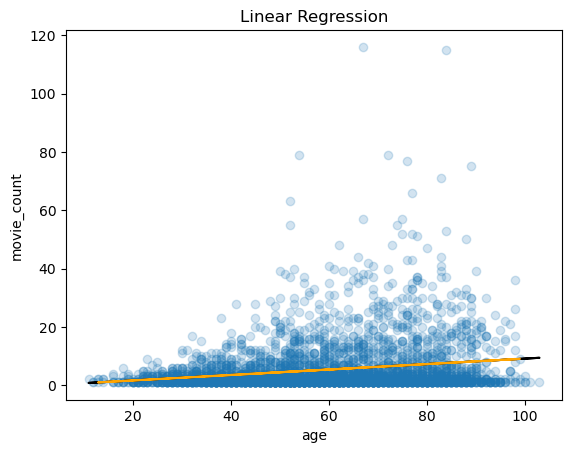

In [22]:
# Visualise the Linear Regression 
plt.title('Linear Regression')
plt.scatter(X, y, alpha=0.2)
plt.plot(X_train, a*X_train + b, color='black')
plt.plot(X_test, y_predicted, color='orange')
plt.xlabel('age')
plt.ylabel('movie_count')
plt.show()

We see that the R-squared value is 0.029 which is not good.

This means that there is not really a linear relationship between actor age and movie_count.

If we instead had looked only at the actors with the top 100 movie_count we would expect to get a better linear relationship.

In [23]:
# R-squared: the proportion of the variation in the dependent variable that is predictable from the independent variable
from sklearn.metrics import r2_score
r2_score(y_test, y_predicted)

0.029122061958939405

## Task 3:  Supervised machine learning: classification

For the supervised machine-learning task, we used decision tree and random forest tree models to predict the gender of a Danish actor/atress based on two features: age and the number of movies they have appeared in.

In [24]:
import numpy as np
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import os
os.environ["PATH"] += r";C:\Program Files\Graphviz\bin"
import graphviz

In [25]:
df_classification = danish_actors

Dropping columns from the dataframe which won't be part for the model.

In [26]:
columns_to_drop = ['actor_id', 'name', 'deathday', 'birthday']
df_classification = df_classification.drop(columns=columns_to_drop)

Selecting the feature input columns, age and movie_count, and the column to predict, gender.

In [27]:
feature_cols = [
    'age',          
    'movie_count' 
]
label_col = 'gender' 

Splitting data into X for the features and y the target

In [28]:
X = df_classification[feature_cols].values
y = df_classification[label_col].values

For clearer visualization of the upcoming decision tree, the gender values were recoded 1 = female and 2 = male.

In [29]:
female = X[y == 1] 
male = X[y == 2]   

In [30]:
#Set test size 
set_prop = 0.20

In [31]:
seed = 10

Split the dataset into training and testing sets.

In [32]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=set_prop, random_state=seed)

Initializing classifers. Randomclassifier will be used for the random forest tree model later.

In [33]:
params = {'max_depth': 4}
classifier = DecisionTreeClassifier(**params)
randomclassifier = RandomForestClassifier(n_estimators = 100, max_depth = 4)

Training the decision tree

In [34]:
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

Exporting the trained tree to graphviz format to draw the desicion tree.

In [35]:
dot_data = tree.export_graphviz(
    classifier,
    out_file=None,
    feature_names=feature_cols,
    class_names=['Unknown', 'female', 'male', 'No-binary'],  # '' for index 0
    filled=True, rounded=True
)

In [36]:
graph = graphviz.Source(dot_data)

#Remove the comment below to get a pdf of the decision tree called danish_actors
#graph.render("danish_actors") 

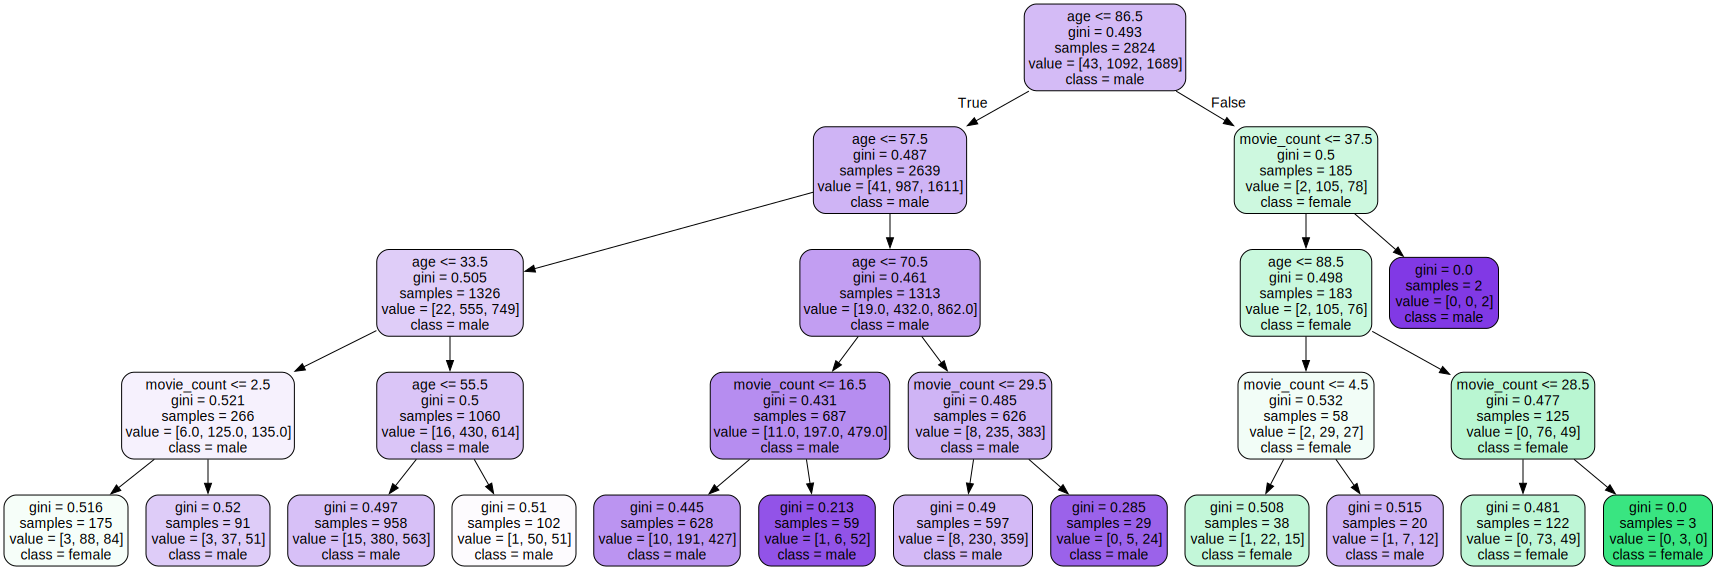

In [37]:
graph

In [38]:
scoring = 'accuracy'

Using the trained tree to predict the gender of the test set.

In [39]:
y_testp = classifier.predict(X_test)
y_testp

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1,
       2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2,

In [40]:
y_test

array([1, 2, 2, 2, 1, 2, 0, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1,
       1, 1, 2, 0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1,
       1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1,
       2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2,
       1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1,
       2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2,
       1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1,

The model achieved an accuracy of only 59.2%, which is quite low. This indicates that it is unable to reliably predict the gender of an actor or actress

In [41]:
print ("Accuracy is ", accuracy_score(y_test,y_testp))

Accuracy is  0.5920679886685553


**Random decision tree**

In [42]:
randomclassifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=4)

We find the best tree of the forest to draw.

In [43]:
best_accuracy = 0
best_tree = None

# Loop through all trees in the random forest
for tree_estimator in randomclassifier.estimators_:
    y_pred = tree_estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    if acc > best_accuracy:
        best_accuracy = acc
        best_tree = tree_estimator

dot_data_best = tree.export_graphviz(
    best_tree,
    out_file=None,
    feature_names=feature_cols,
    class_names=["",'female', 'male'],
    filled=True,
    rounded=True
)


In [44]:
#Display the best tree of the forrest 
graph_best = graphviz.Source(dot_data_best)

#Remove the comment below to get the best random forest tree as pdf
#graph_best.render("best_random_forest_tree")

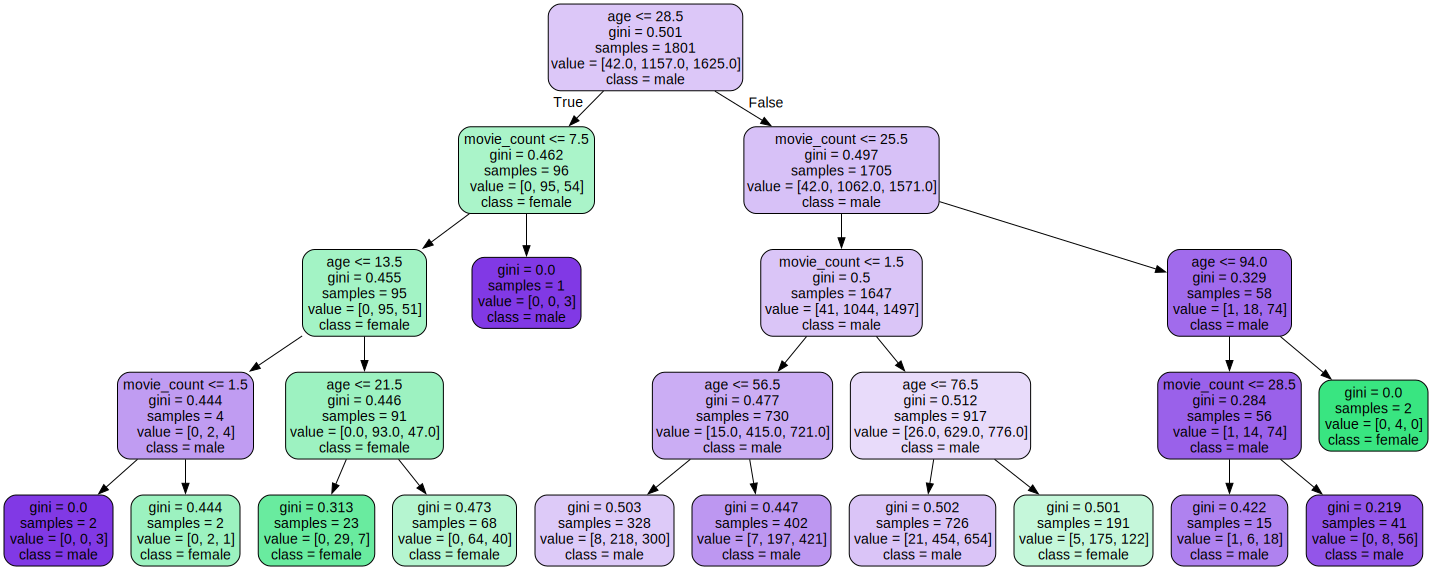

In [45]:
graph_best

In [46]:
scoring_random = 'accuracy'

In [47]:
y_testp = randomclassifier.predict(X_test)
y_testp

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,

In [48]:
y_test

array([1, 2, 2, 2, 1, 2, 0, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1,
       1, 1, 2, 0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1,
       1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1,
       2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2,
       1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1,
       2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2,
       1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1,

The random decision tree performed similarly to the standard decision tree, achieving a low accuracy of ~58.5%, the precise value can be found below

In [49]:
print ("Accuracy is ", accuracy_score(y_test,y_testp))

Accuracy is  0.5878186968838527


Both the decision tree and random forest models achieved only about 58–59% accuracy, which is low. This result—unsurprising given the limited and weakly related data—suggests there is no meaningful relationship between a Danish actor’s age or number of movie appearances and their gender.

## Task 4: Unsupervised machine learning: clustering

For the unsupervised machine-learning task, we apply Mean Shift clustering to Danish movies, using release year, runtime, and genre IDs as features.

In [50]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [51]:
df_clustering = danish_movies

Preparing the movie dataset for clustering by standardizing the numeric features, ensuring that variables like release year or runtime do not skew the results

In [52]:
#Looping through all movie ids to find the unique ids
all_genres = sorted({g for sublist in df_clustering['genre_ids'] for g in sublist})

#Making a one-hot dataframe with as many rows and the df (3990 rows as seen above), all rows have a value of 0
genre_df_clustering = pd.DataFrame(0, index=df_clustering.index,
                        columns=[f'genre_{g}' for g in all_genres])

#Looping through all the genre rows and changing the 0 to 1 cells which match the genre id
for i, genres in enumerate(df_clustering['genre_ids']):
    genre_df_clustering.loc[i, [f'genre_{g}' for g in genres]] = 1


df_clustering_encoded = pd.concat([df_clustering, genre_df_clustering], axis=1)

#Changing release_date to a date-time format and making a new column, release_year, and picks year from the date time as an int
df_clustering_encoded['release_date'] = pd.to_datetime(df_clustering_encoded['release_date'], errors='coerce')
df_clustering_encoded['release_year'] = df_clustering_encoded['release_date'].dt.year

#Scaling the years to not dominate the clustering 
numerical_features = ['release_year', 'runtime']
X_num = df_clustering_encoded[numerical_features]
X_num_scaled = (X_num - X_num.mean()) / X_num.std(ddof=0)
X = np.hstack([X_num_scaled.to_numpy(), genre_df_clustering.values])

Release_year and runtime should be close to zero, which they are.

In [53]:
X_num_scaled.mean(), X_num_scaled.std(ddof=0)

(release_year    2.661799e-15
 runtime         2.539216e-16
 dtype: float64,
 release_year    1.0
 runtime         1.0
 dtype: float64)

Because the dataset is relatively small, the sample size is set to 500 without any noticeable impact on performance.

In [54]:
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500) 

Creating the Mean Shift model.

In [55]:
msmodel = MeanShift(bandwidth=bandwidth, bin_seeding=True)
msmodel.fit(X)

MeanShift(bandwidth=np.float64(1.7103733502032255), bin_seeding=True)

Labeling all movies with a cluster id.

In [56]:
labels = msmodel.labels_
labels

array([6, 6, 6, ..., 0, 0, 0])

Array with the unique cluster ids.

In [57]:
labels_unique = np.unique(labels)
labels_unique

array([0, 1, 2, 3, 4, 5, 6])

Counting the lenth of the array.

In [58]:
n_clusters_ = len(labels_unique)

In [59]:
print(f"Estimated number of clusters = {n_clusters_}")

Estimated number of clusters = 7
